**STEP 1 — Import libraries**

In [7]:
import os
import sys
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder, StandardScaler, label_binarize
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_recall_fscore_support,
    classification_report, confusion_matrix, roc_curve, auc
)
RANDOM_STATE = 42
TEST_SIZE = 0.2

**STEP 2 — Load the dataset**

In [3]:
df = pd.read_csv("Iris.csv")
df.head()

,Id,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,1,5.1,3.5,1.4,0.2,Iris-setosa
1,2,4.9,3.0,1.4,0.2,Iris-setosa
2,3,4.7,3.2,1.3,0.2,Iris-setosa
3,4,4.6,3.1,1.5,0.2,Iris-setosa
4,5,5.0,3.6,1.4,0.2,Iris-setosa


****STEP 3 --Basic Cleaning****

In [4]:
# Drop common ID columns if present
for c in ("Id", "id", "ID"):
    if c in df.columns:
        df = df.drop(columns=[c])

**STEP 4 -- IDENTIFY TARGET COLUMN**

In [23]:

target_col = None
for c in df.columns[::-1]:
    if df[c].dtype == object or pd.api.types.is_categorical_dtype(df[c]):
        target_col = c
        break
if target_col is None:
    # fallback: look for common names
    for name in ("species", "Species", "class", "label"):
        if name in df.columns:
            target_col = name
            break
if target_col is None:
    target_col = df.columns[-1]

print(f"Detected target column: {target_col}")
X = df.drop(columns=[target_col]).values
feature_names = df.drop(columns=[target_col]).columns.tolist()
y = df[target_col].values

Detected target column: Species


**STEP 5 -- PREPROCESSING**

In [8]:

le = LabelEncoder()
y_enc = le.fit_transform(y)
class_names = list(le.classes_)
print("Classes:", class_names)

X_train, X_test, y_train, y_test = train_test_split(
    X, y_enc, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y_enc
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Classes: ['Iris-setosa', 'Iris-versicolor', 'Iris-virginica']


**STEP 6 -- TRAIN THE MODELS**

In [27]:

models = {
    "LogisticRegression": LogisticRegression(max_iter=500, random_state=RANDOM_STATE),
    "SVC": SVC(probability=True, random_state=RANDOM_STATE),
    "RandomForest": RandomForestClassifier(n_estimators=200, random_state=RANDOM_STATE)
}

results = {}
trained = {}

for name, model in models.items():
    print(f"\nTraining {name} ...")
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)

    acc = accuracy_score(y_test, y_pred)
    prec_per_class, rec_per_class, f1_per_class, support = precision_recall_fscore_support(
        y_test, y_pred, average=None, zero_division=0
    )
    prec_macro, rec_macro, f1_macro, _ = precision_recall_fscore_support(
        y_test, y_pred, average="macro", zero_division=0
    )
    report = classification_report(y_test, y_pred, target_names=class_names, zero_division=0)
    cm = confusion_matrix(y_test, y_pred)

    results[name] = {
        "accuracy": acc,
        "precision_macro": prec_macro,
        "recall_macro": rec_macro,
        "f1_macro": f1_macro,
        "classification_report": report,
        "confusion_matrix": cm
    }
    trained[name] = model

    print(f"Model: {name}")
    print(f" Accuracy: {acc:.4f}")
    print(" Classification report:")
    print(report)
    print(" Confusion matrix:")
    print(cm)



Training LogisticRegression ...
Model: LogisticRegression
 Accuracy: 0.9333
 Classification report:
                 precision    recall  f1-score   support

    Iris-setosa       1.00      1.00      1.00        10
Iris-versicolor       0.90      0.90      0.90        10
 Iris-virginica       0.90      0.90      0.90        10

       accuracy                           0.93        30
      macro avg       0.93      0.93      0.93        30
   weighted avg       0.93      0.93      0.93        30

 Confusion matrix:
[[10  0  0]
 [ 0  9  1]
 [ 0  1  9]]

Training SVC ...
Model: SVC
 Accuracy: 0.9667
 Classification report:
                 precision    recall  f1-score   support

    Iris-setosa       1.00      1.00      1.00        10
Iris-versicolor       1.00      0.90      0.95        10
 Iris-virginica       0.91      1.00      0.95        10

       accuracy                           0.97        30
      macro avg       0.97      0.97      0.97        30
   weighted avg       0.97

**STEP 7 -- MODEL COMPARISION**

In [28]:

summary_rows = []
for name, info in results.items():
    summary_rows.append({
        "Model": name,
        "Accuracy": info["accuracy"],
        "Precision_macro": info["precision_macro"],
        "Recall_macro": info["recall_macro"],
        "F1_macro": info["f1_macro"]
    })
summary_df = pd.DataFrame(summary_rows).sort_values("Accuracy", ascending=False).reset_index(drop=True)
print("\nModel comparison summary:")
print(summary_df.to_string(index=False))



Model comparison summary:
             Model  Accuracy  Precision_macro  Recall_macro  F1_macro
               SVC  0.966667         0.969697      0.966667  0.966583
LogisticRegression  0.933333         0.933333      0.933333  0.933333
      RandomForest  0.900000         0.902357      0.900000  0.899749


**STEP 8 -- Choose best model**

In [29]:

best_model_name = summary_df.loc[0, "Model"]
best_model = trained[best_model_name]
print(f"\nBest model selected: {best_model_name}")


Best model selected: SVC


In [30]:
# SVC
best_model = SVC(probability=True)
best_model.fit(X_train, y_train)
y_pred_best = best_model.predict(X_test)

**CONFUSION MATRIX**

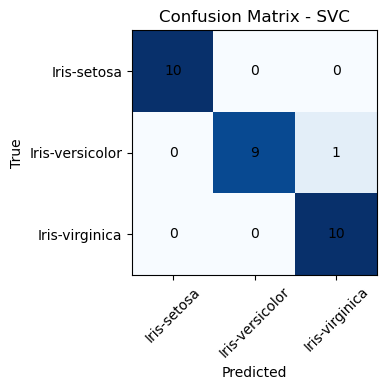

In [31]:

cm = confusion_matrix(y_test, y_pred_best)

plt.figure(figsize=(5,4))
plt.imshow(cm, cmap="Blues")
plt.title("Confusion Matrix - SVC")
plt.xticks(np.arange(len(class_names)), class_names, rotation=45)
plt.yticks(np.arange(len(class_names)), class_names)

for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i, j], ha="center", va="center")

plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()

**PCA 2D Scatter Plot**

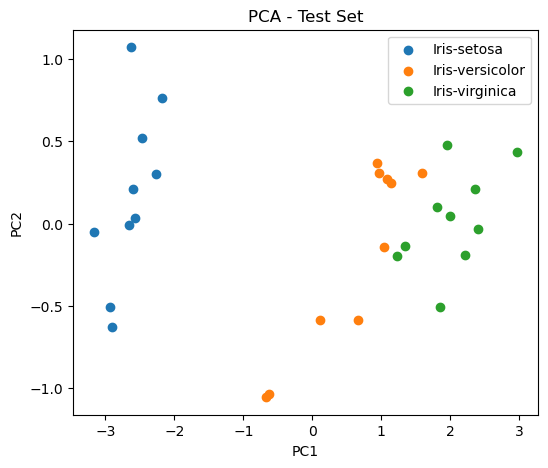

In [32]:

pca = PCA(n_components=2)
X_test_2d = pca.fit_transform(X_test)

plt.figure(figsize=(6,5))
for cls in np.unique(y_test):
    plt.scatter(
        X_test_2d[y_test == cls, 0],
        X_test_2d[y_test == cls, 1],
        label=class_names[cls]
    )

plt.title("PCA - Test Set")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend()
plt.show()


**ROC Curve (Multiclass)**

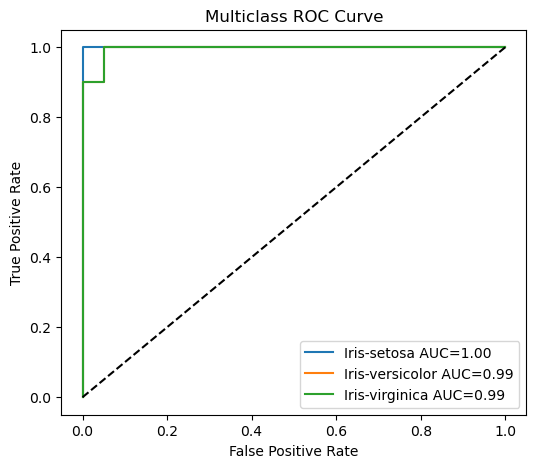

In [33]:

y_test_bin = label_binarize(y_test, classes=np.arange(len(class_names)))
y_score = best_model.predict_proba(X_test)

plt.figure(figsize=(6,5))
for i in range(len(class_names)):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{class_names[i]} AUC={roc_auc:.2f}")

plt.plot([0,1], [0,1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Multiclass ROC Curve")
plt.legend()
plt.show()
